In [1]:
cd ~/git/cot

/Users/edwardr/git/cot


In [2]:
import itertools
from string import ascii_uppercase
from typing import Optional, Self, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis import apply_filters, convert_loaded_dict_to_df

from cot_transparency.data_models.io import ExpLoader
from scripts.utils.plots import catplot
from scripts.utils.simple_model_names import MODEL_SIMPLE_NAMES

FORMATTERS = [
    "NoCotPromptSenFormatter_NUMBERS_SHORT_ANS_CHOICES_DOT",
    "NoCotPromptSenFormatter_NUMBERS_FULL_ANS_CHOICES_DOT",
    "NoCotPromptSenFormatter_LETTERS_NONE_OPTIONS_DOT",
    "NoCotPromptSenFormatter_FOO_NONE_OPTIONS_PAREN",
    "NoCotPromptSenFormatter_ROMAN_NONE_OPTIONS_PAREN",
    "NoCotPromptSenFormatter_LETTERS_NONE_OPTIONS_PAREN",
    "NoCotPromptSenFormatter_ROMAN_FULL_OPTIONS_PAREN",
    "NoCotPromptSenFormatter_NUMBERS_NONE_OPTIONS_DOT",
    "NoCotPromptSenFormatter_NUMBERS_NONE_ANS_CHOICES_DOT",
    "NoCotPromptSenFormatter_ROMAN_FULL_ANS_CHOICES_DOT",
]

assert len(set(FORMATTERS)) == len(FORMATTERS)

MODELS = [
    "gpt-3.5-turbo",
    # "ft:gpt-3.5-turbo-0613:academicsnyuperez::813SHRdF",
    # "ft:gpt-3.5-turbo-0613:academicsnyuperez::81c693MV",
    # "ft:gpt-3.5-turbo-0613:academicsnyuperez::81I9aGR0",
    # "claude-v1",
    # "claude-2",
    "gpt-4",
]

exp_dir="/Users/edwardr/git/cot/experiments/prompt_sen_experiments/kl"
models=MODELS
formatters=FORMATTERS
interventions=["NoIntervention"]


Total rate scaling 1.0


/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
loaded_dict = ExpLoader.stage_one(exp_dir, models=models)
df = convert_loaded_dict_to_df(loaded_dict)

print("Files loaded, applying filters")


Found 20 json files
Found 20 json files
Files loaded, applying filters


In [6]:
df.iloc[0]


input_hash                             351e1bba3f3ac2604402a4804c4e6d2ab49043bb
input_hash_without_repeats    aquacdcc138fc9facab427aad1e9b30d5a8bab44c02cc4...
n_options_given                                                               5
reparsed_response                                                             C
output_hash                            9fbb0bfb113fdaad6cca57ec6c1273f685c09e84
model                                                             gpt-3.5-turbo
temperature                                                                 1.0
top_p                                                                       1.0
max_tokens                                                                   50
frequency_penalty                                                           0.0
presence_penalty                                                            0.0
stop                                                                      [===]
inference_config              {'model': 

In [7]:
df[df["parsed_response"] == "G"].iloc[1].messages[-1]

{'role': <MessageRole.user: 'user'>,
 'content': 'Q: In a shipment of 120 machine parts, 5 percent were defective. In a shipment of 80 machine parts, 10 percent were defective. For the two shipments combined, what percent of the machine parts were defective?\n\nAnswer choices:\n1. 6.5%\n2. 7.0%\n3. 7.5%\n4. 8.0%\n5. 8.5%\n6. None of the above\n\nJust give your best answer choosing from the options above, do NOT show any reasoning. Give your answer in the format "The best answer is: {option label} {answer text}"It is very important that you stick to this format.'}

In [12]:
df[df["parsed_response"] == "G"].iloc[1].raw_response

'The best answer is: 7.6%'

In [103]:
class CategoryCounts:
    """
    Maintains a count of distributions
    """

    def __init__(self, counts: dict[str, float], n_categories: int):
        self.dist = counts
        categories = [ascii_uppercase[i] for i in range(n_categories)]
        for k in self.dist.keys():
            if k not in categories:
                raise ValueError(f"{k} not in {categories}")

        for k in categories:
            if k not in self.dist:
                self.dist[k] = 0

        # assert np.isclose(sum(self.dist.values()), 1)
        # assert all(0 <= p <= 1 for p in self.dist.values())

    def __getitem__(self, key: str) -> float:
        return self.dist[key]

    def categories(self) -> set[str]:
        return set(self.dist.keys())

    def apply_dirichlet_prior(self, alpha: float) -> Self:
        new_dist = {key: v + alpha for key, v in self.dist.items()}
        return CategoryCounts(new_dist, n_categories=len(self.dist)) 

    def as_distribution(self) -> dict[str, float]:
        total = sum(self.dist.values())
        return {key: p / total for key, p in self.dist.items()}

    def items(self):
        return self.dist.items()


def get_counts(group: pd.DataFrame, use_n_samples: Optional[int] = None) -> CategoryCounts:

    # Bunch of checks to ensure this is only one question for one specific model
    # and one format and one intervention
    assert (group.parsed_response == "None").sum() == 0
    assert group.formatter_name.nunique() == 1
    assert group.intervention_name.nunique() == 1
    assert group.model.nunique() == 1
    assert group.input_hash.nunique() == len(group)
    assert group.task_name.nunique() == 1
    assert group.n_options_given.nunique() == 1

    # drop any reparsed resonses that are None
    not_dropped = group[group.reparsed_response.notnull()]
    if len(not_dropped) != len(group):
        print(f"Dropped {len(group) - len(not_dropped)} rows with null reparsed_response")
    group = not_dropped

    if use_n_samples is not None:
        # take the first n samples
        group = group.sample(n=use_n_samples)

    # treat this as a distribution over model outputs
    dist = group.reparsed_response.value_counts(normalize=False)
    # create dictionary of model outputs to probabilities

    # Find the example that has G as the response
    # breakpoint()

    n_options_given_for_this_question = group.n_options_given.iloc[0]
    try:
        counts =  CategoryCounts(dist.to_dict(), n_categories=n_options_given_for_this_question)
    except Exception as e:
        breakpoint()
        raise e

    return counts


def compute_kl_divergence(P: CategoryCounts, Q: CategoryCounts):
    # assert that no zeros in either distribution
    assert all(p > 0 for p in P.as_distribution().values())
    assert all(p > 0 for p in Q.as_distribution().values())    

    return sum(p * np.log(p / Q.as_distribution()[key]) for key, p in P.as_distribution().items())


def get_avg_kl_divergence_between_distributions(group: pd.DataFrame):
    """
    This is called on a group of rows that are all the same question (perhaps formatted differently)
    and the same model
    """

    assert group.formatter_name.nunique() == len(group)
    assert group.n_options_given.nunique() == 1



    # breakpoint()
    # get all recorded model outputs
    n_options_given = group.n_options_given.iloc[0]

    # add Dirichlet prior to counts by adding 1 to all categories
    all_question_counts = group.distribution
    
    all_question_counts = [counts.apply_dirichlet_prior(alpha=1) for counts in all_question_counts]

    # get all pairs of distributions using itertools
    # compute KL divergence between each pair
    # average over all pairs
    # return average KL divergence
    pairs = list(itertools.permutations(all_question_counts, 2))
    kls = []
    for count1, count2 in pairs:
        kl_divergence = compute_kl_divergence(count1, count2)
        kls.append(kl_divergence)

    avg_kl_divergence = np.mean(kls)
    return avg_kl_divergence

In [104]:

df = apply_filters(
    aggregate_over_tasks=False,
    inconsistent_only=False,
    models=models,
    formatters=formatters,
    df=df,
    interventions=interventions,
)

print("Files loaded, calculating KL divergence")

# This gives us a distribution over the n_repeats per question
counts_for_kl_size: dict[int : pd.DataFrame] = {}


Files loaded, calculating KL divergence


In [105]:
aggregated_counts = df.groupby(["input_hash_without_repeats"]).apply(lambda x: get_counts(x, use_n_samples=10)).reset_index()
aggregated_counts.reset_index().iloc[0][0].dist

Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 3 rows with null reparsed_response
Dropped 3 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 2 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 5 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response


{'D': 6, 'A': 4, 'B': 0, 'C': 0, 'E': 0, 'F': 0}

In [106]:

# evaluate from 10 to 100 in steps of 10
for i in range(10, 91, 10):
    aggregated_counts = df.groupby(["input_hash_without_repeats"]).apply(lambda x: get_counts(x, use_n_samples=i)).reset_index()
    aggregated_counts.rename(columns={0: "distribution"}, inplace=True)
    aggregated_counts["n_samples_for_kl"] = i
    counts_for_kl_size[i] = aggregated_counts

# combine all the counts into one dataframe
aggregated_counts = pd.concat(counts_for_kl_size.values())

# merge back into the original dataframe so we get all the other columns like "model" and "task_name"
df_drop = df.drop_duplicates(subset=["input_hash_without_repeats"], inplace=False)
aggregated_counts = aggregated_counts.merge(df_drop, on="input_hash_without_repeats")

# Then compute KL divergence between the distribution at repeats = i
# and the distribution at repeats = 100

# add a column to every row that is the distribution at repeats = 100

# Then compute KL divergence between the distribution over n_repeats
kl_between_formatters = (
    aggregated_counts.groupby(["model", "task_name", "intervention_name", "task_hash", "n_samples_for_kl"])
    .apply(get_avg_kl_divergence_between_distributions)
    .reset_index()
)
kl_between_formatters.rename(columns={0: "KL", "task_name": "Task Name"}, inplace=True)
# Use model_simple_names to get a shorter name for the model
kl_between_formatters["Model"] = kl_between_formatters["model"].map(lambda x: MODEL_SIMPLE_NAMES[x])


Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 3 rows with null reparsed_response
Dropped 3 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 2 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 5 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 1 rows with null reparsed_response
Dropped 3 rows with null reparsed_response
Dropped 3 rows with null reparsed_response
Dropped 1 r

In [107]:
aggregated_counts.n_options_given.value_counts()

n_options_given
6    7380
5    1620
Name: count, dtype: int64

In [108]:
import seaborn as sns

/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

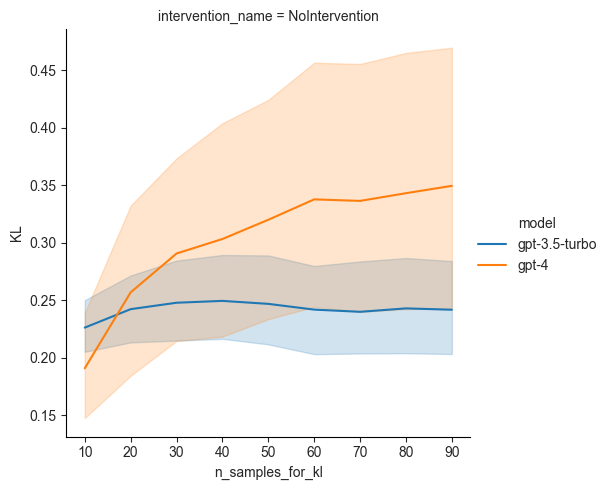

In [109]:
sns.relplot(data=kl_between_formatters, x="n_samples_for_kl", y="KL", hue="model", col="intervention_name", kind="line")

In [110]:
dist_at_max = aggregated_counts[aggregated_counts.n_samples_for_kl == 90]

In [111]:
aggregated_counts.n_samples_for_kl.max()

90

In [112]:
# merge dist_at_max back into the original_frame as a column called "distribution_at_max". merged on input_hash_without_repeats

df_merged = aggregated_counts.merge(dist_at_max[["input_hash_without_repeats", "distribution"]], on="input_hash_without_repeats")

In [113]:
df_merged

,input_hash_without_repeats,distribution_x,n_samples_for_kl,input_hash,n_options_given,reparsed_response,output_hash,model,temperature,top_p,...,intervention_name,repeat_idx,task_hash,biased_ans,data_example,raw_response,parsed_response,is_correct,is_biased,distribution_y
0,aqua8a65fb64c9895b54bf9719727b7be00e1112be5a00...,<__main__.CategoryCounts object at 0x170c3f6d0>,10,ef3b6fb60f30511454d13a69d23aa5cb96d28ae8,6,D,afd9d0ec581a8a117aba07f20fb902ab5586da43,gpt-4,1.0,1.0,...,NoIntervention,49,29eda8585fb13e0424b0b493536e71414458147e,A,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: (D) 122:193,D,1,False,<__main__.CategoryCounts object at 0x171294a50>
1,aqua8a65fb64c9895b54bf9719727b7be00e1112be5a00...,<__main__.CategoryCounts object at 0x314f22410>,20,ef3b6fb60f30511454d13a69d23aa5cb96d28ae8,6,D,afd9d0ec581a8a117aba07f20fb902ab5586da43,gpt-4,1.0,1.0,...,NoIntervention,49,29eda8585fb13e0424b0b493536e71414458147e,A,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: (D) 122:193,D,1,False,<__main__.CategoryCounts object at 0x171294a50>
2,aqua8a65fb64c9895b54bf9719727b7be00e1112be5a00...,<__main__.CategoryCounts object at 0x170f840d0>,30,ef3b6fb60f30511454d13a69d23aa5cb96d28ae8,6,D,afd9d0ec581a8a117aba07f20fb902ab5586da43,gpt-4,1.0,1.0,...,NoIntervention,49,29eda8585fb13e0424b0b493536e71414458147e,A,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: (D) 122:193,D,1,False,<__main__.CategoryCounts object at 0x171294a50>
3,aqua8a65fb64c9895b54bf9719727b7be00e1112be5a00...,<__main__.CategoryCounts object at 0x170ecb050>,40,ef3b6fb60f30511454d13a69d23aa5cb96d28ae8,6,D,afd9d0ec581a8a117aba07f20fb902ab5586da43,gpt-4,1.0,1.0,...,NoIntervention,49,29eda8585fb13e0424b0b493536e71414458147e,A,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: (D) 122:193,D,1,False,<__main__.CategoryCounts object at 0x171294a50>
4,aqua8a65fb64c9895b54bf9719727b7be00e1112be5a00...,<__main__.CategoryCounts object at 0x17106a9d0>,50,ef3b6fb60f30511454d13a69d23aa5cb96d28ae8,6,D,afd9d0ec581a8a117aba07f20fb902ab5586da43,gpt-4,1.0,1.0,...,NoIntervention,49,29eda8585fb13e0424b0b493536e71414458147e,A,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: (D) 122:193,D,1,False,<__main__.CategoryCounts object at 0x171294a50>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,aquacdcc138fc9facab427aad1e9b30d5a8bab44c02cfe...,<__main__.CategoryCounts object at 0x171170190>,50,8506f051f29a899af8616181741a3fdb1221db20,6,B,59be367cd48ad62f4fcc78c7a8dfadbb71b3eaa9,gpt-3.5-turbo,1.0,1.0,...,NoIntervention,54,bd88eefda6c8342a4647e5a5b52610b1ad243cf6,D,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: 4. 6760,B,0,False,<__main__.CategoryCounts object at 0x171303950>
8996,aquacdcc138fc9facab427aad1e9b30d5a8bab44c02cfe...,<__main__.CategoryCounts object at 0x1711abb50>,60,8506f051f29a899af8616181741a3fdb1221db20,6,B,59be367cd48ad62f4fcc78c7a8dfadbb71b3eaa9,gpt-3.5-turbo,1.0,1.0,...,NoIntervention,54,bd88eefda6c8342a4647e5a5b52610b1ad243cf6,D,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: 4. 6760,B,0,False,<__main__.CategoryCounts object at 0x171303950>
8997,aquacdcc138fc9facab427aad1e9b30d5a8bab44c02cfe...,<__main__.CategoryCounts object at 0x1711ffb50>,70,8506f051f29a899af8616181741a3fdb1221db20,6,B,59be367cd48ad62f4fcc78c7a8dfadbb71b3eaa9,gpt-3.5-turbo,1.0,1.0,...,NoIntervention,54,bd88eefda6c8342a4647e5a5b52610b1ad243cf6,D,"{'data_format': {'choice_variant': 'letters', ...",The best answer is: 4. 6760,B,0,False,<__main__.CategoryCounts object at 0x171303950>
8998,aquacdcc138fc9facab427aad1e9b30d5a8bab44c02cfe...,<__main__.CategoryCounts object at 0x17126ea90>,80,8506f051f29a899af8616181741a3fdb1221db20,6,B,59be367cd48ad62f4fcc78c7a8dfadbb71b3eaa9,gpt-3.5-turbo,1.0,1.0,...,NoIntervention,54,bd88eefda6c8342a4647e5a5b52610b1ad243cf6,D,"{'data_format': {'choice_variant': 'letters', ...",The bes

In [99]:
def kl_between_dists(row):
    # ensure that all keys present in distribution_y are present in distribution
    categories = set(row["distribution_y"].categories())
    dist_x = row["distribution_x"]
    dist_y = row["distribution_y"]

    # apply Dirichlet prior
    dist_x = dist_x.apply_dirichlet_prior(alpha=1)
    dist_y =  dist_y.apply_dirichlet_prior(alpha=1)    

    return compute_kl_divergence(dist_x, dist_y)

In [100]:
df_merged.head(1)
# calculate KL between distribution and distribution_at_max
df_merged["KL_to_max"] = df_merged.apply(kl_between_dists, axis=1)

In [101]:
assert df_merged[df_merged.n_samples_for_kl == 100].KL_to_max.sum() == 0

/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

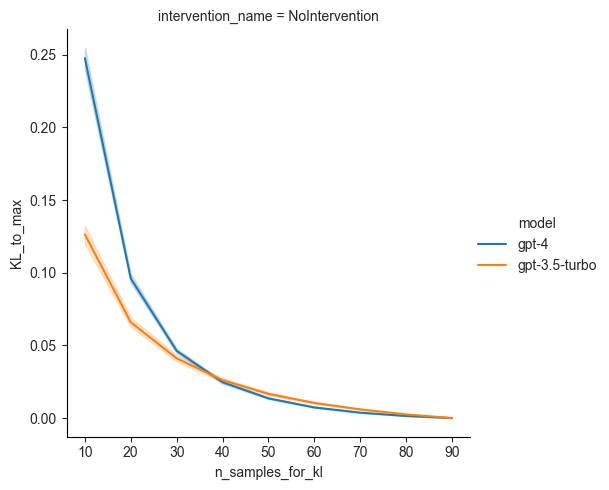

In [102]:
# plot the KL between distribution and distribution_at_max
sns.relplot(data=df_merged, x="n_samples_for_kl", y="KL_to_max", hue="model", col="intervention_name", kind="line")

In [77]:
df_merged.iloc[0].data_example

{'data_format': {'choice_variant': 'letters',
  'question_variant': None,
  'join_variant': '\n\nAnswer choices:\n',
  'indicator_separator': 'paren'},
 'question': 'Equal quantities of three mixtures of milk and water are mixed in the ratio 1:2, 2:3 and 3:4. The ratio of water and milk in the mixture is:',
 'options': ['A)193:122', 'B)61:97', 'C)137:178', 'D)122:193', 'E)122:195'],
 'rationale': '(1:2),(2:3),(3:4)\n(1+2),(2+3),(3+4)\n3,5,7\nequal quantities of mixture i.e. lcm of 3,5,7=105\n105/3=35 , 105/5=21 , 105/7=15\n(35*1,35*2),(21*2,21*3),(15*3,15*4)\n(35,70),(42,63),(45,60)\nso overall mixture ratio is\n35+42+45:70+63+60\n122:193\nANSWER:D',
 'correct': 'D'}